In [ ]:
#| hide
import matplotlib.pylab as plt
import numpy as np
import matplotlib as mpl

# hydro_colors

> Painting HACC Hydrodynamical simulations using Spectral Population Synthesis

## Installation

```sh
pip install hydro_colors
```

## Simple implementation to HACC hydro data

#### First we import the following modules of hydro_colors 

In [ ]:
import hydro_colors as hc
from hydro_colors.load_sim_stellar_catalog import load_hacc_galaxy_data
from hydro_colors.calculate_csp import calc_fluxes_for_galaxy
from hydro_colors.load_sps_library import STELLAR_LIBRARY_DIR

#### Then the galaxy-star catalog from HACC is loaded

In [ ]:
galaxy_tags, _, _, _, _, _, _, _ = hc.load_sim_stellar_catalog.load_hacc_galaxy_data()

#### After selecting a unique galaxy tag, we calculate the SED.
#### This is the rest-frame SED is due to spectral emission alone, and without dust attenuation.  

In [ ]:
galaxy_number = 1
unique_galaxy_tag = np.unique(galaxy_tags)[galaxy_number]

spec_wave_ssp, spec_flux_ssp, spec_csp, flux_proxy, gal_stellar_mass = hc.calculate_csp.calc_fluxes_for_galaxy('../hydro_colors/data/test_hacc_stellar_catalog/Gals_Z0.txt',
                       unique_galaxy_tag,
                       STELLAR_LIBRARY_DIR)

Library shape:  (22, 94, 1963)
Wavelength shape:  (1963,)


#### Finally, we plot SEDs from both SSPs and CSPs

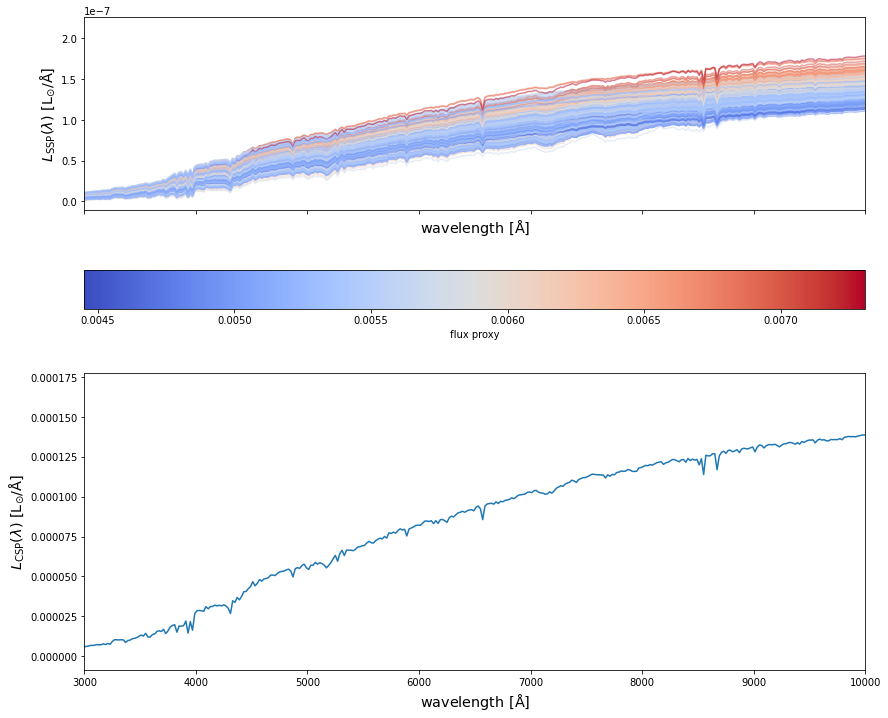

In [ ]:
fig, a = plt.subplots(2,1, figsize=(14, 12), sharex=True, sharey=False)

# Normalize the array vals so they can be mapped to a color
# c_norm = mpl.colors.Normalize(vmin=np.min(np.log10(mass[gal_tag_cond])), vmax=np.max(np.log10(mass[gal_tag_cond])))
c_norm = mpl.colors.Normalize(vmin=np.min(flux_proxy), vmax=np.max(flux_proxy))


# Pick a colormap
c_map  = mpl.cm.coolwarm

# Scalar mappable of normalized array to colormap
s_map  = mpl.cm.ScalarMappable(cmap=c_map, norm=c_norm)
s_map.set_array([])


for idx in range(spec_flux_ssp.shape[0]):
    
    # spec_flux_ssp[idx] = spec_ssp(age_hydro[ssp_id], metal_hydro[ssp_id], mass[ssp_id])
    a[0].plot(spec_wave_ssp, spec_flux_ssp[idx], 
              # color=s_map.to_rgba(np.log10(mass[ssp_id])), 
              color=s_map.to_rgba(flux_proxy[idx]), 
              alpha=0.5)

    
# Adding the colorbar
fig.colorbar(s_map, ax = a[0], 
             orientation = 'horizontal', 
             # label=r'stellar mass', pad=0.2)
             label=r'flux proxy', pad=0.2)
    

#####################################################################

a[1].plot(spec_wave_ssp, spec_csp)


# a[0].set_xlim(3e3, 1e4)
# a[1].set_yscale('log')
# a[1].set_xscale('log')
a[1].set_xlim(3e3, 1e4)

# a[0].set_yscale('log')

a[0].set_xlabel(r'${\rm wavelength\ [\AA]}$', fontsize = 'x-large')
a[1].set_xlabel(r'${\rm wavelength\ [\AA]}$', fontsize = 'x-large')
a[0].set_ylabel(r'$L_{\rm SSP}(\lambda)\ {\rm [L_{\odot}/\AA]}$', fontsize = 'x-large')
a[1].set_ylabel(r'$L_{\rm CSP}(\lambda)\ {\rm [L_{\odot}/\AA]}$', fontsize = 'x-large')


plt.show()

#### Finally we plot the SEDs of the galaxy, along with SEDs of the individual SSPs

## Under the hood

In [ ]:
# ssp_interpolation import *
from hydro_colors.load_sps_library import *
from hydro_colors.load_sim_stellar_catalog import *

Library shape:  (22, 94, 1963)
Wavelength shape:  (1963,)


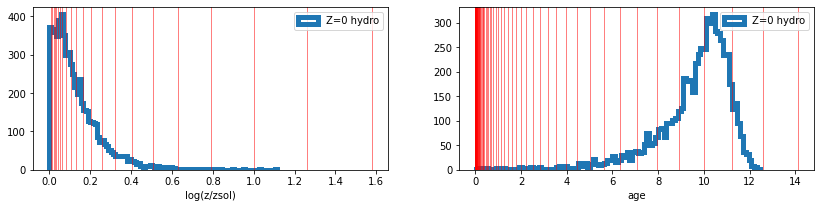

In [ ]:
spec_flux, spec_wave = load_fsps_spectral_library()
age_fsps_gyr, Z_padova_fsps = load_fsps_age_metallicity()
gal_tag, stellar_idx, metal_hydro, mass, age_hydro, x, y, z = load_hacc_galaxy_data()


f, a = plt.subplots(1,2, figsize=(14, 3))
a[0].hist(metal_hydro, bins = 100, histtype='step', lw=5, label='Z=0 hydro');
[a[0].axvline(_x, linewidth=1, color='r', alpha=0.5) for _x in Z_padova_fsps];
a[0].legend()
a[0].set_xlabel('log(z/zsol)')


a[1].hist(age_hydro, bins = 100, histtype='step', lw=5, label='Z=0 hydro');
[a[1].axvline(_x, linewidth=1, color='r', alpha=0.5) for _x in age_fsps_gyr];
a[1].legend()
a[1].set_xlabel('age')

plt.show()